In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip /content/drive/MyDrive/temp/facialexpression.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

In [ ]:
TRAIN_DIR = '/content/train/train'
TEST_DIR = '/content/test/test'

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+'/'+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

neutral Completed
fear Completed
angry Completed
sad Completed
happy Completed
surprise Completed
disgust Completed


,image,label
0,/content/train/train/surprise/Training_5869815...,surprise
1,/content/train/train/neutral/Training_59285594...,neutral
2,/content/train/train/happy/Training_79484871.jpg,happy
3,/content/train/train/happy/Training_76501326.jpg,happy
4,/content/train/train/sad/Training_36513747.jpg,sad


In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

neutral Completed
fear Completed
angry Completed
sad Completed
happy Completed
surprise Completed
disgust Completed


,image,label
0,/content/test/test/neutral/PrivateTest_1826446...,neutral
1,/content/test/test/neutral/PrivateTest_4096878...,neutral
2,/content/test/test/neutral/PrivateTest_8320849...,neutral
3,/content/test/test/neutral/PublicTest_59740213...,neutral
4,/content/test/test/neutral/PublicTest_1534576.jpg,neutral


In [ ]:
##eda

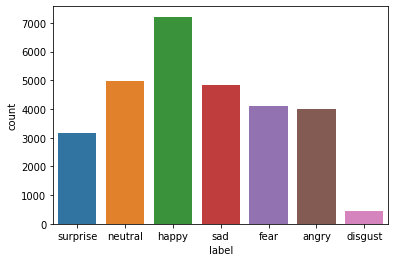

In [ ]:
sns.countplot(train['label'])

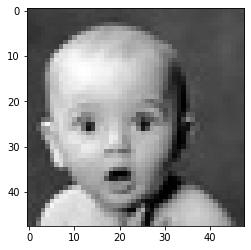

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

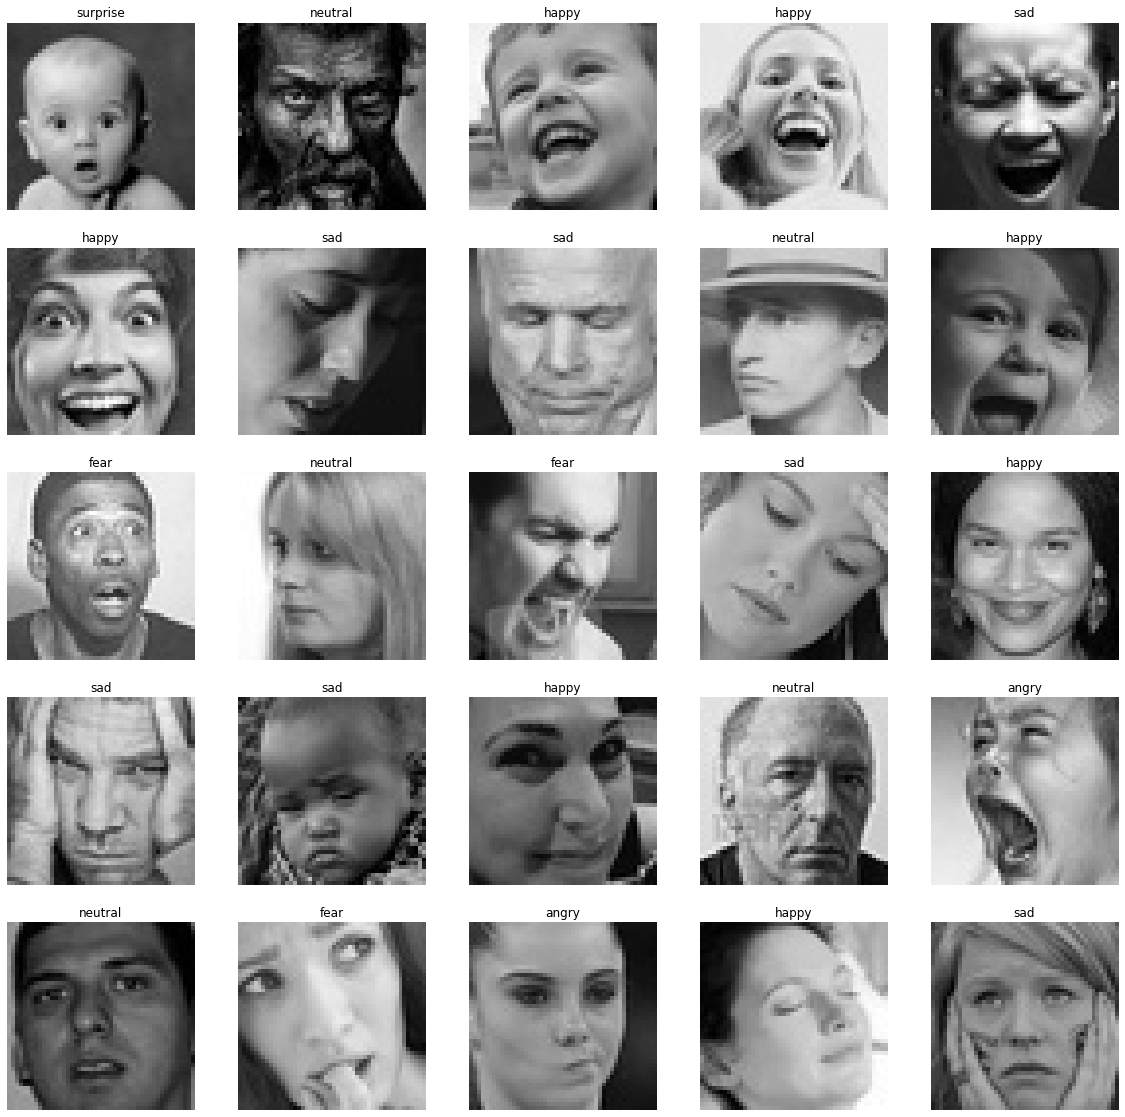

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [ ]:
##feature extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

In [ ]:
##model creation

In [ ]:

model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
225/225 [==============================] - 22s 55ms/step - loss: 1.8235 - accuracy: 0.2441 - val_loss: 1.8139 - val_accuracy: 0.2471
Epoch 2/200
225/225 [==============================] - 11s 51ms/step - loss: 1.8013 - accuracy: 0.2526 - val_loss: 1.7902 - val_accuracy: 0.2471
Epoch 3/200
225/225 [==============================] - 12s 52ms/step - loss: 1.7588 - accuracy: 0.2672 - val_loss: 1.6946 - val_accuracy: 0.2992
Epoch 4/200
225/225 [==============================] - 12s 52ms/step - loss: 1.6870 - accuracy: 0.3129 - val_loss: 1.6101 - val_accuracy: 0.3559
Epoch 5/200
225/225 [==============================] - 12s 55ms/step - loss: 1.5942 - accuracy: 0.3703 - val_loss: 1.5005 - val_accuracy: 0.4110
Epoch 6/200
225/225 [==============================] - 13s 56ms/step - loss: 1.5082 - accuracy: 0.4122 - val_loss: 1.3999 - val_accuracy: 0.4514
Epoch 7/200
225/225 [==============================] - 12s 54ms/step - loss: 1.4577 - accuracy: 0.4348 - val_loss: 1.3365 - val_ac

In [ ]:
##plot results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

In [ ]:
##test with image data

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');